In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

palette = sns.color_palette("Set2")

params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': 14,
          'axes.titlesize': 18,
          'xtick.labelsize': 14*0.75,
          'ytick.labelsize': 14*0.75}
plt.rcParams.update(params)

randomState = 42

import xgboost
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix

## Read and preprocess the data

In [2]:
dfFFR = pd.read_pickle('../intermediatePickles/FFRRQs.pkl')
dfgX = pd.read_pickle('../intermediatePickles/gXRQs.pkl')

# Assign truth
dfFFR['gX'] = 0
dfgX['gX'] = 1

nSamplesEach = min(len(dfFFR), len(dfgX))

# Create one data set
df = pd.concat([dfFFR.head(nSamplesEach), dfgX.head(nSamplesEach)], ignore_index = True).sample(frac = 1).reset_index(drop = True)

# Pop the truth
signalType = df.pop('gX')

In [3]:
df

s1AFT1  s1AFT5  s1AFT10  s1AFT25  s1AFT50  s1AFT75  s1AFT90  s1AFT95  \
0           30      40       50       70      100      130      180      220   
1           20      30       40       60       80      120      190      270   
2           20      30       40       50       70      110      160      190   
3           40      50       50       60       70       90      120      150   
4           30      40       50       60       90      120      180      230   
...        ...     ...      ...      ...      ...      ...      ...      ...   
139755      30      40       50       60       90      130      170      200   
139756      40      50       60       70       90      120      160      190   
139757      30      40       50       60       90      130      180      230   
139758      40      50       50       70       90      130      180      210   
139759      20      40       40       60       90      120      160      190   

        s1AFT99       TBA  clusterSize  topPeakFraction  bottomPeakFraction  
0           430 -0.769860    47.387194         0.034405            0.035826  
1          1370 -0.836028    40.473167         0.074544            0.284462  
2           250 -0.802076    88.960003         0.085449            0.034036  
3           230  1.000000    70.000000         0.000000            0.000000  
4           510 -0.879941    41.198728         0.097138            0.191777  
...         ...       ...          ...              ...                 ...  
139755      300 -0.751707    49.123890         0.063135            0.029401  
139756      270 -0.812764    38.033765         0.145801            0.028801  
139757      380 -0.772328    46.748863         0.089307            0.032426  
139758      270 -0.797528    40.796894         0.055443            0.042057  
139759      250 -0.751461    40.452713         0.133674            0.095722  

[139760 rows x 13 columns]

### Create AFTs from successive differences

In [4]:
aftVars = [var for var in df.columns.to_list() if 's1AFT' in var]
aftVars = sorted(aftVars, key = lambda x: int(x[5:]))
s1AFT5np = df.s1AFT5.to_numpy()
s1AFT95np = df.s1AFT95.to_numpy()
for i, aft in enumerate(aftVars[:-1]):
    df[aft + '_diff'] = (df[aftVars[i+1]] - df[aftVars[i]]) / (s1AFT95np - s1AFT5np)

#### Training variables

In [5]:
oldTrainingVars = aftVars + ['TBA', 'bottomPeakFraction', 'clusterSize', 'topPeakFraction']

In [6]:
kendallCorrOld = df[oldTrainingVars].corr(method = 'kendall')

sns.heatmap(kendallCorrOld, vmin = -1, vmax = 1, annot = False,
            square = True, cmap = sns.diverging_palette(10, 220, sep=80, n = 80), 
            cbar_kws = {'label' : 'Kendall Correlation'})
plt.title('Old AFT Variable Correlations')
plt.show()

In [7]:
trainingVars = df.columns.difference(aftVars + ['s1AFT1_diff'])
trainingVars

Index(['TBA', 'bottomPeakFraction', 'clusterSize', 's1AFT10_diff',
       's1AFT25_diff', 's1AFT50_diff', 's1AFT5_diff', 's1AFT75_diff',
       's1AFT90_diff', 's1AFT95_diff', 'topPeakFraction'],
      dtype='object')

In [8]:
kendallCorr = df[trainingVars].corr(method = 'kendall')

sns.heatmap(kendallCorr, vmin = -1, vmax = 1, annot = False,
            square = True, cmap = sns.diverging_palette(10, 220, sep=80, n = 80), 
            cbar_kws = {'label' : 'Kendall Correlation'})
plt.title('AFT difference Variable Correlations')
plt.show()

In [9]:
visualVars = trainingVars.difference(['s1AFT5_diff', 's1AFT75_diff', 's1AFT90_diff'])

In [11]:
pairplot = sns.pairplot(pd.concat([df, signalType], axis = 1).head(100), 
                        vars = visualVars.to_list(),
                        hue = 'gX', markers = '+')

## Train Test Split

In [10]:
xUnscaled = np.array(df[trainingVars])

# Split training and testing sets
xTrainUnscaled, xTestUnscaled, yTrain, yTest = train_test_split(df[trainingVars], 
                                                                signalType, 
                                                                test_size = 0.3,
                                                                random_state = randomState,
                                                                shuffle = True)

## XGBoost

In [11]:
dTrain = xgboost.DMatrix(xTrainUnscaled, label = yTrain)
dTest = xgboost.DMatrix(xTestUnscaled, label = yTest)

In [30]:
# Save the data for cross validation
dTrain.save_binary("dTrain.buffer")
dTest.save_binary("dTest.buffer")

In [12]:
param = {'max_depth'         : 6,
         'min_child_weight'  : 3,
         'learning_rate'     : 0.08,
         'objective'         : 'binary:logistic',
         'subsample'         : 0.7,
         'colsample_bylevel' : 1,
         'min_split_loss'    : 0.5, # "Gamma" in the XGBoost paper
         'lambda'            : 1, # L2 regularization
        }

In [13]:
nBoosts = 1000 # Maximum number of rounds
progress = dict()
watchlist =  [ (dTrain, 'train'), (dTest, 'validation')] # As it is training, the BDT will evaluate on these datasets

In [14]:
BST = xgboost.train(param, dTrain, nBoosts,
                    evals = watchlist,
                    verbose_eval = 50,
                    early_stopping_rounds = 50, # You can set this to stop training when the validation set starts to turn over (overtraining is occurring)
                    evals_result = progress)

[0]	train-error:0.09146	validation-error:0.09266
Multiple eval metrics have been passed: 'validation-error' will be used for early stopping.

Will train until validation-error hasn't improved in 50 rounds.
[50]	train-error:0.07602	validation-error:0.07782
[100]	train-error:0.06749	validation-error:0.07138
[150]	train-error:0.06385	validation-error:0.07000
[200]	train-error:0.06090	validation-error:0.06971
Stopping. Best iteration:
[197]	train-error:0.06129	validation-error:0.06967



In [17]:
# Save the model for CV
BST.save_model('../models/RQModel.model')

In [15]:
# Assuming the FRF RFR split is at BST output = 0.5
confusionMatrixBST = confusion_matrix(np.array(yTest), np.round(BST.predict(dTest)), normalize = 'all')
pd.DataFrame(confusionMatrixBST, 
             index = ['Actual FFR', 'Actual gX'], 
             columns = ['Predicted FFR', 'Predicted gX'])

Predicted FFR  Predicted gX
Actual FFR       0.459144      0.038614
Actual gX        0.031363      0.470879

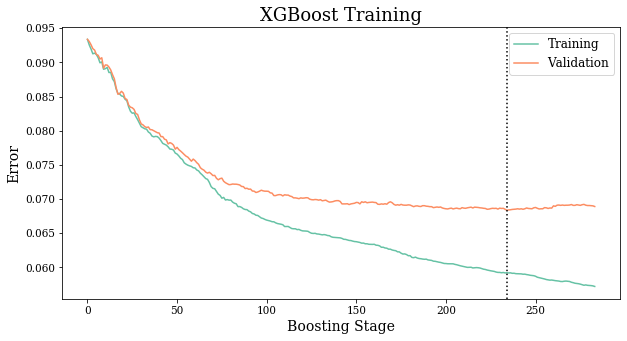

In [19]:
plt.figure(figsize = (10,5))

plt.plot(progress['train']['error'], color = palette[0], label='Training')
plt.plot(progress['validation']['error'], color = palette[1], label ='Validation')
plt.axvline(np.argmin(progress['validation']['error']), ls = ':', color = 'k')

plt.xlabel('Boosting Stage')
plt.ylabel('Error')
plt.title('XGBoost Training')
plt.legend()
plt.show()

In [16]:
yPredTestXGB = BST.predict(dTest)
yPredTrainXGB = BST.predict(dTrain)

yPredTestRFR_XGB = yPredTestXGB[yTest == 1]
yPredTrainRFR_XGB = yPredTrainXGB[yTrain == 1]

yPredTestFFR_XGB = yPredTestXGB[yTest == 0]
yPredTrainFFR_XGB = yPredTrainXGB[yTrain == 0]

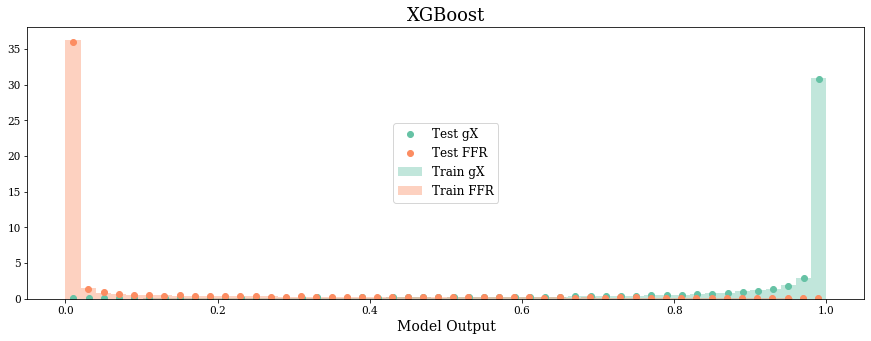

In [17]:
nBins = 50

plt.figure(figsize = (15, 5))
plt.hist(yPredTrainRFR_XGB,
         bins = nBins,
         density = True,
         alpha = 0.4,
         color = palette[0],
         label = "Train gX")
counts, binEdges = np.histogram(yPredTestRFR_XGB, bins = nBins, density = True)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2
plt.plot(binCenters,
         counts,
         marker = 'o',
         ls = "None",
         color = palette[0],
         label = "Test gX")

plt.hist(yPredTrainFFR_XGB,
         bins = nBins,
         density = True,
         alpha = 0.4,
         color = palette[1],
         label = "Train FFR")
counts, binEdges = np.histogram(yPredTestFFR_XGB, bins = nBins, density = True)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2
plt.plot(binCenters,
         counts,
         marker = 'o',
         ls = "None",
         color = palette[1],
         label = "Test FFR")
plt.legend(loc = 'center')
plt.title('XGBoost')
plt.xlabel('Model Output')
plt.show()

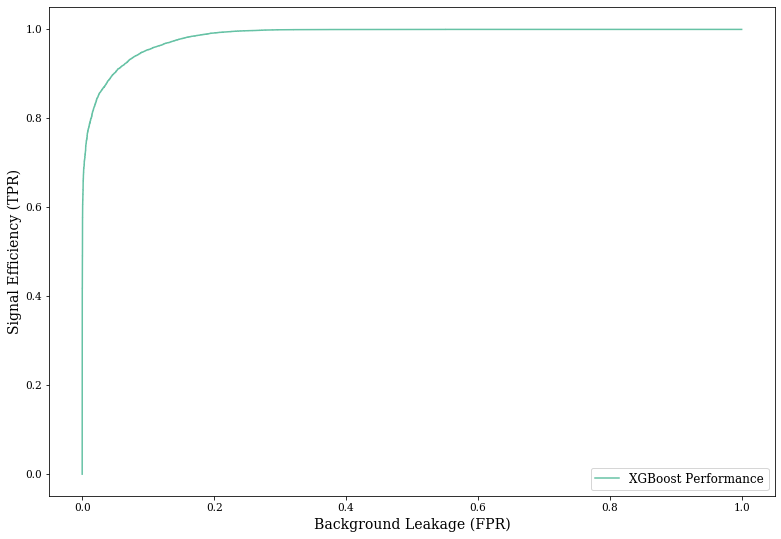

In [18]:
FalsePosTestXGB, TruePosTestXGB, _ = roc_curve(yTest, yPredTestXGB, pos_label = 1)

plt.plot(FalsePosTestXGB, TruePosTestXGB, color = palette[0], label = "XGBoost Performance")
plt.xlabel('Background Leakage (FPR)')
plt.ylabel('Signal Efficiency (TPR)')

plt.legend()
plt.show()

In [23]:
pickle.dump([FalsePosTestXGB, TruePosTestXGB], open('../intermediatePickles/tempXGBoostCompare.pkl', 'wb'))

In [24]:
f'AUC score for XGBoost is {round(roc_auc_score(yTest, BST.predict(dTest)), 4)}'

'AUC score for XGBoost is 0.986'

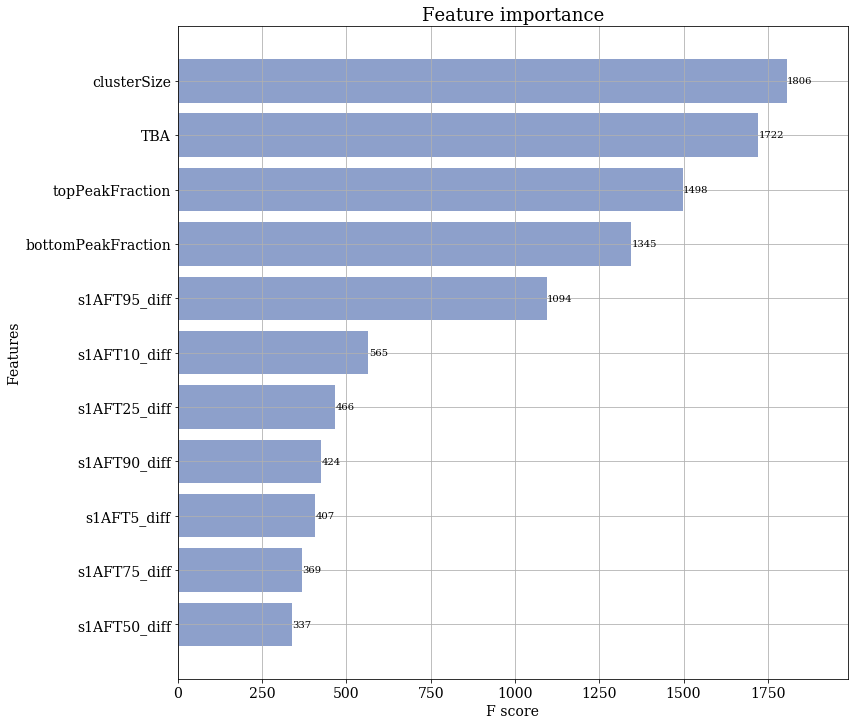

In [25]:
f, featureImpAxes = plt.subplots(figsize=(12,12))
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plot_importance(BST, ax = featureImpAxes, height = 0.8, color = palette[2])
plt.show()

# Hyperparameter Optimization

See python scripts in `HPO/`